# Centroid Exploration
Exploratory notebook for working on birdnet embeddings

### Imports and Setup

In [1]:
import pandas as pd
import os
import numpy as np
from annotation_post_processing import *

In [2]:
embeddingColumns = [str(i) for i in range(420)]
columnNames = ["START", "END"] + embeddingColumns
path = './input/xc_embeddings/'

In [3]:
def generate_embeddings_from_file(path, filename):
    with open(path + filename, 'r') as f:
        data = f.read()
    with open(path + filename, 'w') as f:
        f.write(",".join(data.split("\t")))
    file_df = pd.read_csv(path + filename, names = columnNames)
    file_df["IN FILE"] = filename[:filename.index(".birdnet")] + ".wav"
    return file_df

def generate_embeddings(path):
    df = pd.DataFrame()
    for filename in os.listdir(path):
        try:
            df = pd.concat([df, generate_embeddings_from_file(path, filename)], ignore_index = True)
        except Exception as e:
            print("Something went wrong with: " + filename)
    df["PATH"] = path
    columns = df.columns.tolist()
    columns = columns[-2:] + columns[:-2]
    df = df[columns]
    df = df.sort_values(["IN FILE", "START"], ascending = True)
    df = df.reset_index(drop = True)
    return df

In [4]:
embeddings_df = generate_embeddings(path)
annotations_df = pd.read_csv("xc_annotations.csv")

# removing duplicate annotations
grouped_annotations = annotations_df.groupby(["IN FILE", "OFFSET"])["CONFIDENCE"].max()
annotations_df["MANUAL ID"] = annotations_df.apply(lambda x: x["MANUAL ID"] \
    if grouped_annotations.loc[x["IN FILE"], x["OFFSET"]] == x["CONFIDENCE"] else pd.NA, axis = 1)
annotations_df = annotations_df.dropna(subset = ["MANUAL ID"]).reset_index(drop = True)

In [5]:
manual_df = pd.read_csv("mixed_bird_sample.csv")
manual_df = pd.DataFrame(annotation_chunker(manual_df, 3))
manual_df["MANUAL ID"] = manual_df["MANUAL ID"].apply(lambda x: " ".join(x.split(" ")[:2]))
manual_df

,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID
0,Amazona-aestiva-52744.wav,19.5657,0,0.0,3.0,44100,Amazona aestiva
1,Amazona-aestiva-52744.wav,19.5657,0,3.0,3.0,44100,Amazona aestiva
2,Amazona-aestiva-52744.wav,19.5657,0,6.0,3.0,44100,Amazona aestiva
3,Amazona-aestiva-52744.wav,19.5657,0,9.0,3.0,44100,Amazona aestiva
4,Amazona-aestiva-52744.wav,19.5657,0,12.0,3.0,44100,Amazona aestiva
...,...,...,...,...,...,...,...
976,Zenaida-auriculata-105264.wav,82.9910,0,48.0,3.0,44100,Zenaida auriculata
977,Zenaida-auriculata-105264.wav,82.9910,0,57.0,3.0,44100,Zenaida auriculata
978,Zenaida-auriculata-105264.wav,82.9910,0,60.0,3.0,44100,Zenaida auriculata
979,Zenaida-auriculata-105264.wav,82.9910,0,66.0,3.0,44100,Zenaida auriculata


In [6]:
# Data cleaning to avoid file does not exist
intersection_files = list(set(embeddings_df["IN FILE"].unique()).intersection(set(annotations_df["IN FILE"])))
embeddings_df = embeddings_df[embeddings_df["IN FILE"].isin(intersection_files)]
annotations_df = annotations_df[annotations_df["IN FILE"].isin(intersection_files)]
manual_df = manual_df[manual_df["IN FILE"].isin(intersection_files)]

In [7]:
# Adding manual ids to embeddings
k = 0
def embed_id(x):
    filenames = manual_df["IN FILE"] == x["IN FILE"]
    offsets = np.isclose(manual_df["OFFSET"], x["START"])
    both = filenames & offsets
    if not np.any(both):
        return "No bird"
    return manual_df[both]["MANUAL ID"].iloc[0]

embeddings_df["MANUAL ID"] = embeddings_df.apply(embed_id, axis = 1)
embeddings_df["FILE SPECIES"] = embeddings_df["IN FILE"].apply(lambda x: " ".join(x.split("-")[:2]))

In [8]:
# To change all of the birdnet annotations manual ids to species names
birdnet_species = pd.read_csv("birdnet_species.csv")
birdnet_species.columns = ["SPECIES"]
birdnet_species = birdnet_species.assign(
    SPECIES = birdnet_species["SPECIES"].apply(lambda x: x.split("_")[0]), 
    COMMON = birdnet_species["SPECIES"].apply(lambda x: x.split("_")[1])
)
birdnet_species = birdnet_species.set_index("COMMON").to_dict()["SPECIES"]

annotations_df["MANUAL ID"] = annotations_df["MANUAL ID"].apply(lambda x: birdnet_species[x])

In [9]:
embeddings_df

,IN FILE,PATH,START,END,0,1,2,3,4,5,...,412,413,414,415,416,417,418,419,MANUAL ID,FILE SPECIES
0,Amazona-aestiva-52744.wav,./input/xc_embeddings/,0.0,3.0,0.762929,1.000408,0.432522,0.452946,0.656488,0.737373,...,0.400595,0.883827,1.193243,0.283634,1.542077,0.981433,0.721521,1.163081,Amazona aestiva,Amazona aestiva
1,Amazona-aestiva-52744.wav,./input/xc_embeddings/,3.0,6.0,0.503359,1.043012,1.005796,0.746995,0.574083,0.559189,...,0.300669,0.443966,0.643819,0.377903,1.428960,1.383765,1.037601,0.670695,Amazona aestiva,Amazona aestiva
2,Amazona-aestiva-52744.wav,./input/xc_embeddings/,6.0,9.0,0.524409,1.336747,0.553674,0.334472,0.743905,0.547638,...,0.180524,0.618135,0.340749,0.336239,1.109600,0.923518,0.698893,0.677029,Amazona aestiva,Amazona aestiva
3,Amazona-aestiva-52744.wav,./input/xc_embeddings/,9.0,12.0,0.436074,0.507001,0.915852,0.123285,0.442399,0.537654,...,0.510933,0.126209,0.478544,0.347008,1.033731,0.530908,0.840781,0.675452,Amazona aestiva,Amazona aestiva
4,Amazona-aestiva-52744.wav,./input/xc_embeddings/,12.0,15.0,0.433620,1.535415,0.639228,0.053500,0.584404,0.518180,...,0.233526,0.647830,0.581350,0.101694,0.756994,0.921158,1.034858,0.702051,Amazona aestiva,Amazona aestiva
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,Zenaida-auriculata-105264.wav,./input/xc_embeddings/,66.0,69.0,0.774719,0.172968,2.005917,0.446872,0.182429,1.709142,...,0.648165,0.610772,0.648035,0.946822,1.422127,0.063739,0.265166,0.462670,Zenaida auriculata,Zenaida auriculata
1270,Zenaida-auriculata-105264.wav,./input/xc_embeddings/,69.0,72.0,0.865834,0.252022,2.261983,0.285904,0.507300,1.582644,...,0.627719,0.182417,0.545958,0.731052,1.079015,0.151970,0.582425,0.567783,Zenaida auriculata,Zenaida auriculata
1271,Zenaida-auriculata-105264.wav,./input/xc_embeddings/,72.0,75.0,0.516543,0.430446,2.036958,0.136788,0.701989,1.653021,...,0.402779,0.267759,0.269648,0.489614,0.008608,0.085612,0.132973,0.294987,No bird,Zenaida auriculata
1272,Zenaida-auriculata-105264.wav,./input/xc_embeddings/,75.0,78.0,0.243208,0.508803,1.145117,0.905772,0.488338,1.596147,...,0.136255,0.410212,0.399387,0.348331,0.103727,0.372924,1.253011,0.634606,No bird,Zenaida auriculata


In [10]:
annotations_df

,FOLDER,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID,CONFIDENCE
0,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,0.0,3.0,48000,Amazona ochrocephala,0.4382
1,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,3.0,3.0,48000,Amazona aestiva,0.9149
2,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,6.0,3.0,48000,Amazona ochrocephala,0.3460
3,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,9.0,3.0,48000,Amazona aestiva,0.8246
4,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,12.0,3.0,48000,Amazona aestiva,0.8547
...,...,...,...,...,...,...,...,...,...
1103,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,66.0,3.0,48000,Zenaida auriculata,0.9999
1104,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,69.0,3.0,48000,Zenaida auriculata,0.9994
1105,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,72.0,3.0,48000,Zenaida auriculata,0.5543
1106,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,75.0,3.0,48000,Columba oenas,0.2265


In [11]:
manual_df

,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID
0,Amazona-aestiva-52744.wav,19.5657,0,0.0,3.0,44100,Amazona aestiva
1,Amazona-aestiva-52744.wav,19.5657,0,3.0,3.0,44100,Amazona aestiva
2,Amazona-aestiva-52744.wav,19.5657,0,6.0,3.0,44100,Amazona aestiva
3,Amazona-aestiva-52744.wav,19.5657,0,9.0,3.0,44100,Amazona aestiva
4,Amazona-aestiva-52744.wav,19.5657,0,12.0,3.0,44100,Amazona aestiva
...,...,...,...,...,...,...,...
976,Zenaida-auriculata-105264.wav,82.9910,0,48.0,3.0,44100,Zenaida auriculata
977,Zenaida-auriculata-105264.wav,82.9910,0,57.0,3.0,44100,Zenaida auriculata
978,Zenaida-auriculata-105264.wav,82.9910,0,60.0,3.0,44100,Zenaida auriculata
979,Zenaida-auriculata-105264.wav,82.9910,0,66.0,3.0,44100,Zenaida auriculata


In [12]:
# Checking to see if same number of files are in all of the dataframes
print(len(embeddings_df["IN FILE"].unique()), len(annotations_df["IN FILE"].unique()), len(manual_df["IN FILE"].unique()))

99 99 99


### Centroid Work
Computing and using centroids

In [13]:
# From here on out we only need annotations that have the corresponding bird name to the file name
annotations_df = annotations_df[annotations_df["MANUAL ID"] == \
    annotations_df["IN FILE"].apply(lambda x: " ".join(x.split("-")[:2]))].reset_index(drop=True)
annotations_df

,FOLDER,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID,CONFIDENCE
0,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,3.0,3.0,48000,Amazona aestiva,0.9149
1,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,9.0,3.0,48000,Amazona aestiva,0.8246
2,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,12.0,3.0,48000,Amazona aestiva,0.8547
3,../passive-acoustic-biodiversity/BirdnetEmbedd...,Ara-macao-213006.wav,91.846531,1,0.0,3.0,48000,Ara macao,0.5748
4,../passive-acoustic-biodiversity/BirdnetEmbedd...,Ara-macao-213006.wav,91.846531,1,3.0,3.0,48000,Ara macao,0.8920
...,...,...,...,...,...,...,...,...,...
885,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,60.0,3.0,48000,Zenaida auriculata,0.9991
886,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,63.0,3.0,48000,Zenaida auriculata,0.8420
887,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,66.0,3.0,48000,Zenaida auriculata,0.9999
888,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,69.0,3.0,48000,Zenaida auriculata,0.9994


In [14]:
def compute_centroid(embeddings: pd.DataFrame):
    embeddings = embeddings[embeddingColumns + ["MANUAL ID"]].groupby(["MANUAL ID"]).mean()
    return embeddings.iloc[embeddings.index != "No bird"]
    
centroids = compute_centroid(embeddings_df)
centroids

,0,1,2,3,4,5,6,7,8,9,...,410,411,412,413,414,415,416,417,418,419
MANUAL ID,,,,,,,,,,,,,,,,,,,,,
Amazona aestiva,0.560687,1.072503,0.683008,0.386466,0.645384,0.616011,0.772218,0.325648,1.081730,0.567418,...,0.896648,0.872424,0.390523,0.504940,0.763253,0.328341,1.256140,0.966329,0.942158,0.823391
Ara macao,0.564027,0.871401,0.502843,0.622838,0.696249,0.382950,0.776924,0.342210,0.718597,1.411454,...,0.315187,0.794281,0.292774,0.779816,0.235724,0.515734,0.384097,0.785698,0.363951,1.554132
Ara militaris,1.214105,0.369536,1.042510,0.559688,0.608336,0.849109,0.635370,0.363462,0.832816,0.903953,...,0.391257,0.614933,0.955280,0.527139,0.364256,0.749389,0.249899,1.151845,1.336844,1.419928
Ardea cocoi,1.103238,0.334180,0.452383,1.197593,1.401584,1.327356,0.644746,0.362785,1.006831,1.266900,...,0.918835,0.967696,0.615965,1.602407,0.474351,0.437833,0.938617,0.526910,1.164118,1.404300
Arremon taciturnus,0.756803,0.385792,0.588807,0.716058,0.397458,0.564821,0.677480,0.670120,0.720474,0.189670,...,0.706126,0.556626,0.443236,0.908634,0.314928,0.757964,0.153847,1.115794,0.957189,0.389759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tyranneutes stolzmanni,0.579383,0.411730,0.501542,0.613901,0.373659,1.054727,0.707350,0.345036,0.529682,0.693154,...,0.564900,0.714818,0.766899,0.561767,0.208083,0.627803,0.577068,1.145025,0.737161,0.476697
Vireo flavoviridis,1.634787,1.121489,0.835642,1.130937,0.750634,0.832871,0.491632,1.209299,0.737773,0.555667,...,1.355748,0.665934,0.613470,0.500599,1.245701,0.903052,0.914862,1.034102,1.274577,0.434229
Vireo olivaceus,1.004495,1.352000,0.930062,0.709140,0.611395,1.018261,0.638085,0.781468,0.808436,0.525986,...,0.603966,0.766603,0.413129,0.419521,0.639329,0.379863,0.848888,0.787669,1.325546,0.696447


In [15]:
def add_distances(embeddings: pd.DataFrame):
    embeddings = embeddings.assign(DISTANCE=embeddings.apply(lambda x: pd.NA if x["FILE SPECIES"] not in centroids.index else \
        np.linalg.norm(x[embeddingColumns] - centroids.loc[x["FILE SPECIES"]]), axis = 1))
    embeddings = embeddings.dropna(subset = ["DISTANCE"])
    return embeddings

embeddings_df = add_distances(embeddings_df)
embeddings_df

,IN FILE,PATH,START,END,0,1,2,3,4,5,...,413,414,415,416,417,418,419,MANUAL ID,FILE SPECIES,DISTANCE
0,Amazona-aestiva-52744.wav,./input/xc_embeddings/,0.0,3.0,0.762929,1.000408,0.432522,0.452946,0.656488,0.737373,...,0.883827,1.193243,0.283634,1.542077,0.981433,0.721521,1.163081,Amazona aestiva,Amazona aestiva,4.863358
1,Amazona-aestiva-52744.wav,./input/xc_embeddings/,3.0,6.0,0.503359,1.043012,1.005796,0.746995,0.574083,0.559189,...,0.443966,0.643819,0.377903,1.428960,1.383765,1.037601,0.670695,Amazona aestiva,Amazona aestiva,3.920867
2,Amazona-aestiva-52744.wav,./input/xc_embeddings/,6.0,9.0,0.524409,1.336747,0.553674,0.334472,0.743905,0.547638,...,0.618135,0.340749,0.336239,1.109600,0.923518,0.698893,0.677029,Amazona aestiva,Amazona aestiva,4.322208
3,Amazona-aestiva-52744.wav,./input/xc_embeddings/,9.0,12.0,0.436074,0.507001,0.915852,0.123285,0.442399,0.537654,...,0.126209,0.478544,0.347008,1.033731,0.530908,0.840781,0.675452,Amazona aestiva,Amazona aestiva,6.212745
4,Amazona-aestiva-52744.wav,./input/xc_embeddings/,12.0,15.0,0.433620,1.535415,0.639228,0.053500,0.584404,0.518180,...,0.647830,0.581350,0.101694,0.756994,0.921158,1.034858,0.702051,Amazona aestiva,Amazona aestiva,5.075293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,Zenaida-auriculata-105264.wav,./input/xc_embeddings/,66.0,69.0,0.774719,0.172968,2.005917,0.446872,0.182429,1.709142,...,0.610772,0.648035,0.946822,1.422127,0.063739,0.265166,0.462670,Zenaida auriculata,Zenaida auriculata,6.01272
1270,Zenaida-auriculata-105264.wav,./input/xc_embeddings/,69.0,72.0,0.865834,0.252022,2.261983,0.285904,0.507300,1.582644,...,0.182417,0.545958,0.731052,1.079015,0.151970,0.582425,0.567783,Zenaida auriculata,Zenaida auriculata,6.087351
1271,Zenaida-auriculata-105264.wav,./input/xc_embeddings/,72.0,75.0,0.516543,0.430446,2.036958,0.136788,0.701989,1.653021,...,0.267759,0.269648,0.489614,0.008608,0.085612,0.132973,0.294987,No bird,Zenaida auriculata,8.247163
1272,Zenaida-auriculata-105264.wav,./input/xc_embeddings/,75.0,78.0,0.243208,0.508803,1.145117,0.905772,0.488338,1.596147,...,0.410212,0.399387,0.348331,0.103727,0.372924,1.253011,0.634606,No bird,Zenaida auriculata,10.894265


#### Starting Predictions

In [16]:
annotations_df["DISTANCE"] = annotations_df.apply(lambda x: \
    embeddings_df[(embeddings_df["IN FILE"] == x["IN FILE"]) & (np.isclose(embeddings_df["START"], x["OFFSET"]))]["DISTANCE"], axis = 1).fillna(method = "bfill", axis = 1).iloc[:,0]
annotations_df = annotations_df.dropna(axis = 0, subset = ["DISTANCE"])
annotations_df = annotations_df.reset_index(drop = True)
annotations_df

,FOLDER,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID,CONFIDENCE,DISTANCE
0,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,3.0,3.0,48000,Amazona aestiva,0.9149,3.920867
1,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,9.0,3.0,48000,Amazona aestiva,0.8246,6.212745
2,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,12.0,3.0,48000,Amazona aestiva,0.8547,5.075293
3,../passive-acoustic-biodiversity/BirdnetEmbedd...,Ara-macao-213006.wav,91.846531,1,0.0,3.0,48000,Ara macao,0.5748,6.362419
4,../passive-acoustic-biodiversity/BirdnetEmbedd...,Ara-macao-213006.wav,91.846531,1,3.0,3.0,48000,Ara macao,0.8920,5.756693
...,...,...,...,...,...,...,...,...,...,...
882,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,60.0,3.0,48000,Zenaida auriculata,0.9991,7.374536
883,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,63.0,3.0,48000,Zenaida auriculata,0.8420,7.105726
884,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,66.0,3.0,48000,Zenaida auriculata,0.9999,6.012720
885,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,69.0,3.0,48000,Zenaida auriculata,0.9994,6.087351


In [17]:
max_distances = embeddings_df[["MANUAL ID", "DISTANCE"]].groupby("MANUAL ID").max()
max_distances

,DISTANCE
MANUAL ID,
Amazona aestiva,6.212745
Ara macao,6.362419
Ara militaris,6.857282
Ardea cocoi,3.575518
Arremon taciturnus,6.327966
...,...
Tyranneutes stolzmanni,7.972986
Vireo flavoviridis,8.871333
Vireo olivaceus,10.005874


In [18]:
annotations_df["IS OUTLIER"] = annotations_df.apply(lambda x: x["DISTANCE"] > max_distances.loc[x["MANUAL ID"]], axis = 1)
annotations_df

,FOLDER,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID,CONFIDENCE,DISTANCE,IS OUTLIER
0,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,3.0,3.0,48000,Amazona aestiva,0.9149,3.920867,False
1,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,9.0,3.0,48000,Amazona aestiva,0.8246,6.212745,False
2,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,12.0,3.0,48000,Amazona aestiva,0.8547,5.075293,False
3,../passive-acoustic-biodiversity/BirdnetEmbedd...,Ara-macao-213006.wav,91.846531,1,0.0,3.0,48000,Ara macao,0.5748,6.362419,False
4,../passive-acoustic-biodiversity/BirdnetEmbedd...,Ara-macao-213006.wav,91.846531,1,3.0,3.0,48000,Ara macao,0.8920,5.756693,False
...,...,...,...,...,...,...,...,...,...,...,...
882,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,60.0,3.0,48000,Zenaida auriculata,0.9991,7.374536,False
883,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,63.0,3.0,48000,Zenaida auriculata,0.8420,7.105726,False
884,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,66.0,3.0,48000,Zenaida auriculata,0.9999,6.012720,False
885,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,69.0,3.0,48000,Zenaida auriculata,0.9994,6.087351,False


### Results Exploration

In [19]:
annotations_df["IS OUTLIER"].sum()

15

In [20]:
def add_correct(x):
    filenames = manual_df["IN FILE"] == x["IN FILE"]
    offsets = np.isclose(manual_df["OFFSET"], x["OFFSET"])
    both = filenames & offsets
    return (not np.any(both)) == x["IS OUTLIER"]

annotations_df["CORRECT ID"] = annotations_df.apply(add_correct, axis = 1)
annotations_df

,FOLDER,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID,CONFIDENCE,DISTANCE,IS OUTLIER,CORRECT ID
0,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,3.0,3.0,48000,Amazona aestiva,0.9149,3.920867,False,True
1,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,9.0,3.0,48000,Amazona aestiva,0.8246,6.212745,False,True
2,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,42.592063,1,12.0,3.0,48000,Amazona aestiva,0.8547,5.075293,False,True
3,../passive-acoustic-biodiversity/BirdnetEmbedd...,Ara-macao-213006.wav,91.846531,1,0.0,3.0,48000,Ara macao,0.5748,6.362419,False,True
4,../passive-acoustic-biodiversity/BirdnetEmbedd...,Ara-macao-213006.wav,91.846531,1,3.0,3.0,48000,Ara macao,0.8920,5.756693,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
882,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,60.0,3.0,48000,Zenaida auriculata,0.9991,7.374536,False,True
883,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,63.0,3.0,48000,Zenaida auriculata,0.8420,7.105726,False,False
884,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,66.0,3.0,48000,Zenaida auriculata,0.9999,6.012720,False,True
885,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zenaida-auriculata-105264.wav,180.660726,1,69.0,3.0,48000,Zenaida auriculata,0.9994,6.087351,False,True


In [21]:
# Printing number of incorrect predictions
print(len(annotations_df["CORRECT ID"]) - annotations_df["CORRECT ID"].sum())

23


In [22]:
from statistics import *
local_stats = automated_labeling_statistics(annotations_df, manual_df, "general")
local_stats

/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statistics.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(clip_stats_df)
/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statistics.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(clip_stats_df)
/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statistics.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(clip_stats_df)
/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statis

Processed 50 clips in 6.4 seconds


/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statistics.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(clip_stats_df)
/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statistics.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(clip_stats_df)
/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statistics.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(clip_stats_df)
/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statis

,FOLDER,IN FILE,MANUAL ID,TRUE POSITIVE,FALSE POSITIVE,FALSE NEGATIVE,TRUE NEGATIVE,UNION,PRECISION,RECALL,F1,Global IoU
0,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,Amazona aestiva,9.0,0.0,9.0,24.592063,18.0,1.000000,0.500000,0.666667,0.500000
1,../passive-acoustic-biodiversity/BirdnetEmbedd...,Ara-macao-213006.wav,Ara macao,33.0,0.0,6.0,52.846521,39.0,1.000000,0.846154,0.916667,0.846154
2,../passive-acoustic-biodiversity/BirdnetEmbedd...,Ara-militaris-391487.wav,Ara militaris,39.0,0.0,9.0,68.610604,48.0,1.000000,0.812500,0.896552,0.812500
3,../passive-acoustic-biodiversity/BirdnetEmbedd...,Ardea-cocoi-476510.wav,Ardea cocoi,6.0,0.0,0.0,13.504792,6.0,1.000000,1.000000,1.000000,1.000000
4,../passive-acoustic-biodiversity/BirdnetEmbedd...,Arremon-taciturnus-31078.wav,Arremon taciturnus,12.0,0.0,3.0,47.665479,15.0,1.000000,0.800000,0.888889,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...
91,../passive-acoustic-biodiversity/BirdnetEmbedd...,Vireo-flavoviridis-125805.wav,Vireo flavoviridis,33.0,0.0,0.0,44.270187,33.0,1.000000,1.000000,1.000000,1.000000
92,../passive-acoustic-biodiversity/BirdnetEmbedd...,Vireo-flavoviridis-252424.wav,Vireo flavoviridis,117.0,0.0,0.0,142.930833,117.0,1.000000,1.000000,1.000000,1.000000
93,../passive-acoustic-biodiversity/BirdnetEmbedd...,Vireo-olivaceus-381598.wav,Vireo olivaceus,39.0,0.0,0.0,47.465292,39.0,1.000000,1.000000,1.000000,1.000000
94,../passive-acoustic-biodiversity/BirdnetEmbedd...,Xenops-rutilans-522420.wav,Xenops rutilans,18.0,0.0,3.0,34.955354,21.0,1.000000,0.857143,0.923077,0.857143


In [23]:
global_stats = global_dataset_statistics(local_stats)
global_stats

,MANUAL ID,PRECISION,RECALL,F1,Global IoU
0,bird,0.957159,0.875258,0.914378,0.842262


In [24]:
local_stats_new = automated_labeling_statistics(annotations_df[annotations_df["CORRECT ID"]], manual_df, "general")
local_stats_new

/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statistics.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(clip_stats_df)
/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statistics.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(clip_stats_df)
/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statistics.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(clip_stats_df)
/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statis

Processed 50 clips in 6.9 seconds


/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statistics.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(clip_stats_df)
/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statistics.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(clip_stats_df)
/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statistics.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  statistics_df = statistics_df.append(clip_stats_df)
/Users/pranjalchatterjee/Documents/Internship/passive-acoustic-biodiversity/BirdnetEmbeddings/statis

,FOLDER,IN FILE,MANUAL ID,TRUE POSITIVE,FALSE POSITIVE,FALSE NEGATIVE,TRUE NEGATIVE,UNION,PRECISION,RECALL,F1,Global IoU
0,../passive-acoustic-biodiversity/BirdnetEmbedd...,Amazona-aestiva-52744.wav,Amazona aestiva,9.0,0.0,9.0,24.592063,18.0,1.000000,0.500000,0.666667,0.500000
1,../passive-acoustic-biodiversity/BirdnetEmbedd...,Ara-macao-213006.wav,Ara macao,33.0,0.0,6.0,52.846521,39.0,1.000000,0.846154,0.916667,0.846154
2,../passive-acoustic-biodiversity/BirdnetEmbedd...,Ara-militaris-391487.wav,Ara militaris,39.0,0.0,9.0,68.610604,48.0,1.000000,0.812500,0.896552,0.812500
3,../passive-acoustic-biodiversity/BirdnetEmbedd...,Ardea-cocoi-476510.wav,Ardea cocoi,6.0,0.0,0.0,13.504792,6.0,1.000000,1.000000,1.000000,1.000000
4,../passive-acoustic-biodiversity/BirdnetEmbedd...,Arremon-taciturnus-31078.wav,Arremon taciturnus,12.0,0.0,3.0,47.665479,15.0,1.000000,0.800000,0.888889,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...
91,../passive-acoustic-biodiversity/BirdnetEmbedd...,Vireo-flavoviridis-125805.wav,Vireo flavoviridis,33.0,0.0,0.0,44.270187,33.0,1.000000,1.000000,1.000000,1.000000
92,../passive-acoustic-biodiversity/BirdnetEmbedd...,Vireo-flavoviridis-252424.wav,Vireo flavoviridis,117.0,0.0,0.0,142.930833,117.0,1.000000,1.000000,1.000000,1.000000
93,../passive-acoustic-biodiversity/BirdnetEmbedd...,Vireo-olivaceus-381598.wav,Vireo olivaceus,39.0,0.0,0.0,47.465292,39.0,1.000000,1.000000,1.000000,1.000000
94,../passive-acoustic-biodiversity/BirdnetEmbedd...,Xenops-rutilans-522420.wav,Xenops rutilans,18.0,0.0,3.0,34.955354,21.0,1.000000,0.857143,0.923077,0.857143


In [25]:
global_stats_new = global_dataset_statistics(local_stats_new)
global_stats_new

,MANUAL ID,PRECISION,RECALL,F1,Global IoU
0,bird,0.982639,0.875258,0.925845,0.861929


In [26]:
# Self-written functions
# Printing precision and recall
def global_stats(annotations: pd.DataFrame, manual: pd.DataFrame):
    statistics = pd.DataFrame({"Previous": [0, 0], "New": [0, 0]}, index = ["Precision", "Recall"])
    TP_previous = annotations.apply(lambda x: ((manual["IN FILE"] == x["IN FILE"]) & (manual["OFFSET"] == x["OFFSET"])).sum() != 0, axis = 1).sum()
    FP_previous = annotations.apply(lambda x: ((manual["IN FILE"] == x["IN FILE"]) & (manual["OFFSET"] == x["OFFSET"])).sum() == 0, axis = 1).sum()
    FN_previous = manual.apply(lambda x: ((annotations["IN FILE"] == x["IN FILE"]) & (annotations["OFFSET"] == x["OFFSET"])).sum() == 0, axis = 1).sum()
    statistics["Previous"] = pd.Series([TP_previous / (TP_previous + FP_previous), TP_previous / (TP_previous + FN_previous)], index = ["Precision", "Recall"])
    
    annotations = annotations[annotations["CORRECT ID"]]
    
    TP = annotations.apply(lambda x: ((manual["IN FILE"] == x["IN FILE"]) & (manual["OFFSET"] == x["OFFSET"])).sum() != 0, axis = 1).sum()
    FP = annotations.apply(lambda x: ((manual["IN FILE"] == x["IN FILE"]) & (manual["OFFSET"] == x["OFFSET"])).sum() == 0, axis = 1).sum()
    FN = manual.apply(lambda x: ((annotations["IN FILE"] == x["IN FILE"]) & (annotations["OFFSET"] == x["OFFSET"])).sum() == 0, axis = 1).sum()
    statistics["New"] = pd.Series([TP / (TP + FP), TP / (TP + FN)], index = ["Precision", "Recall"])
    
    return statistics

global_stats(annotations_df, manual_df)

,Previous,New
Precision,0.957159,0.982639
Recall,0.865443,0.865443


### Visualizations

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

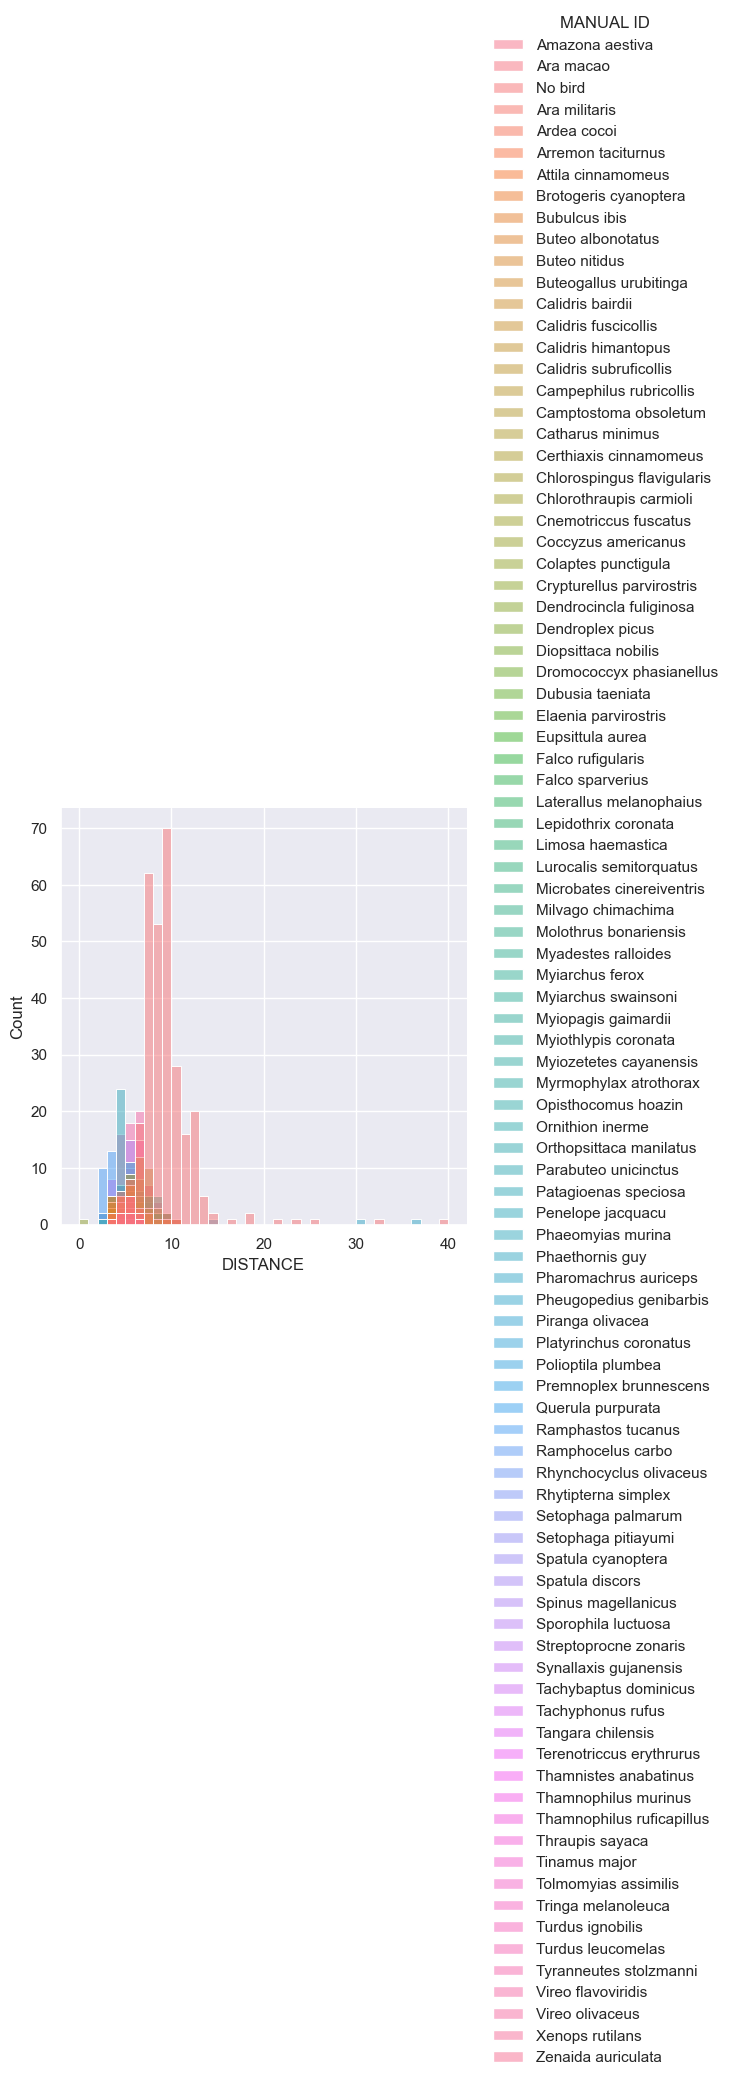

In [32]:
# Visualization of variation of distances
plot = sns.displot(embeddings_df[["MANUAL ID", "DISTANCE"]], x = "DISTANCE", hue = embeddings_df["MANUAL ID"], binwidth = 1, legend = True)
plot

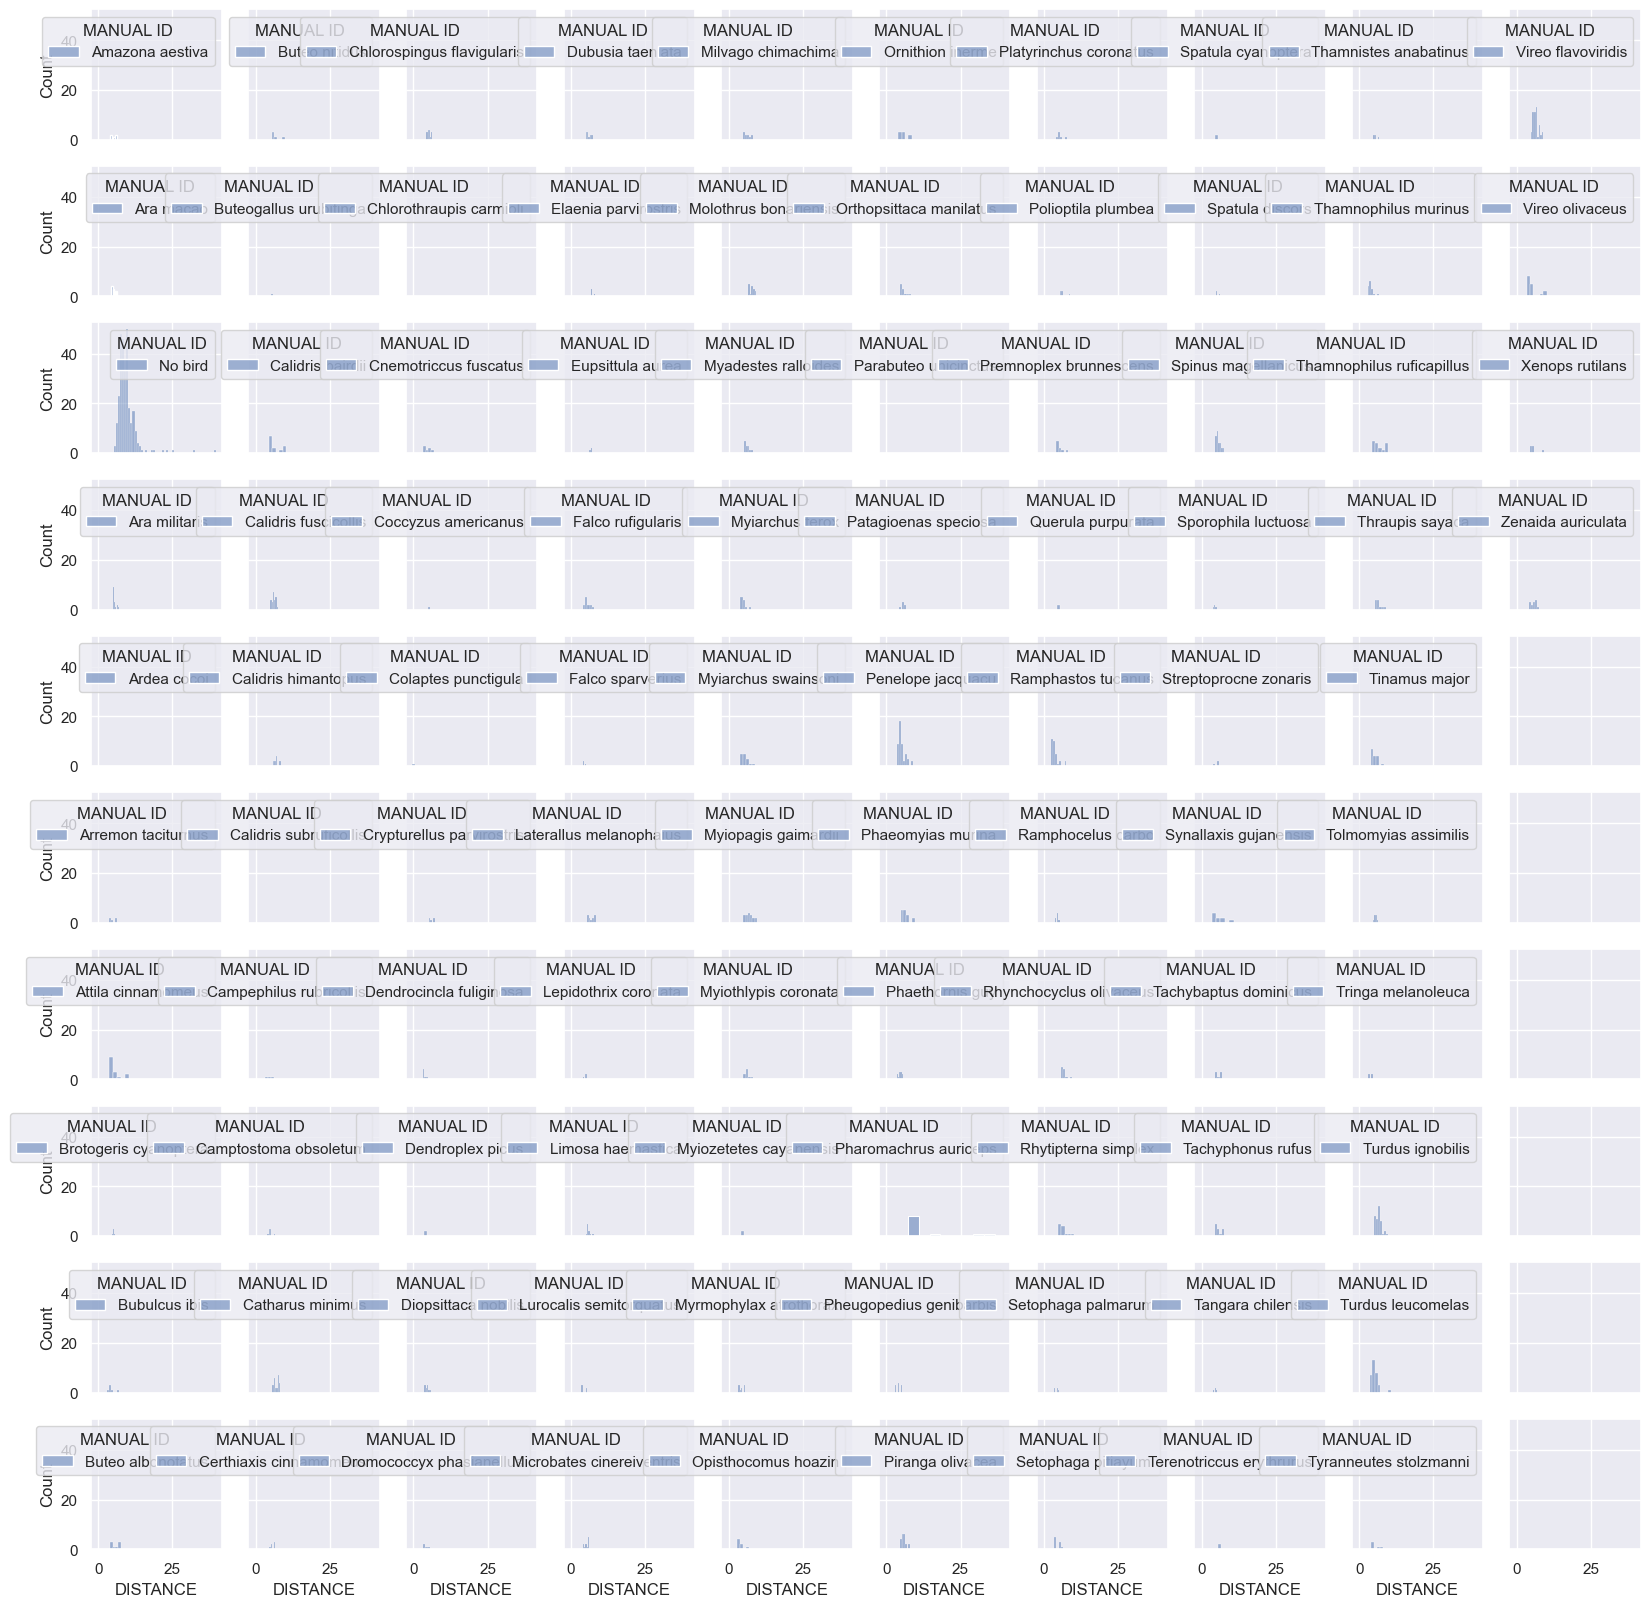

In [47]:
# Plotting each species separately
figure, axes = plt.subplots(10, 10, figsize = (20, 20), sharex = True, sharey = True)

x = 0
y = 0

for species in embeddings_df["MANUAL ID"].unique():
    sns.histplot(ax = axes[x, y], data = embeddings_df[embeddings_df["MANUAL ID"] == species][["MANUAL ID", "DISTANCE"]], x = "DISTANCE", hue = "MANUAL ID", legend = True)
    if x < 9:
        x += 1
    else:
        x = 0
        y += 1